# Step 1: Import Python Libraries

In the first step, we will import Python libraries `pandas`, `numpy`, and `scipy.stats`. These three libraries are for data processing and calculations.

We also imported `seaborn` for visualization and `cosine_similarity` for calculating similarity score.

In [1]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Step 2: Download And Read In Data

This tutorial uses the movielens dataset. This dataset contains actual user ratings of movies.

In step 2, we will follow the steps below to get the datasets:
1. Go to https://grouplens.org/datasets/movielens/
2. Download the 100k dataset with the file name "ml-latest-small.zip"
3. Unzip "ml-latest-small.zip"
4. Copy the "ml-latest-small" folder to your project folder

### There are multiple datasets in the 100k movielens folder.we will use two csv files ratings and movies.


In [2]:
#Read the data
Ratings=pd.read_csv('ratings.csv')

In [3]:
Ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,02/04/2005 23:53
1,1,29,3.5,02/04/2005 23:31
2,1,32,3.5,02/04/2005 23:33
3,1,47,3.5,02/04/2005 23:32
4,1,50,3.5,02/04/2005 23:29


There are four columns in the ratings dataset, userID, movieID, rating, and timestamp.

The dataset has over 100k records, and there is no missing data.

In [4]:
Ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048575 non-null  int64  
 1   movieId    1048575 non-null  int64  
 2   rating     1048575 non-null  float64
 3   timestamp  1048575 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 32.0+ MB


In [5]:
# Number of movies
print('The ratings dataset has', Ratings['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', Ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(Ratings['rating'].unique()))

The ratings dataset has 14026 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


The Movies dataset has movieId,title and genres.

In [6]:
#Reading movies dataset.
Movies=pd.read_csv('movies.csv')

In [7]:
Movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Using 'movieID' as the matching key, we appended movie information to the rating dataset and named it 'df'. So now we have the movie tile and movie rating in the same dataset!

In [8]:
df=pd.merge(Ratings,Movies,on='movieId',how='inner')

In [9]:
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,02/04/2005 23:53,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,25/12/1996 15:26,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,27/11/1996 08:19,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,23/06/1996 20:36,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,28/10/1996 13:29,Jumanji (1995),Adventure|Children|Fantasy


# Step 3: Exploratory Data Analysis (EDA)

In step 3, we need to filter the movies and keep only those with over 100 ratings for the analysis. This is to make the calculation manageable by the Google Colab memory.

To do that, we first group the movies by title, count the number of ratings, and keep only the movies with greater than 100 ratings.

The average ratings for the movies are calculated as well.

From the `.info()` output, we can see that there are 134 movies left.

In [10]:
AGG_Ratings=df.groupby('title').agg(mean_rating=('rating','mean'),number_of_ratings=('rating','count')).reset_index()
AGG_Ratings_GT100=AGG_Ratings[AGG_Ratings['number_of_ratings']>100]
AGG_Ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2108 entries, 8 to 14018
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2108 non-null   object 
 1   mean_rating        2108 non-null   float64
 2   number_of_ratings  2108 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 65.9+ KB


In [11]:
#popular movies
AGG_Ratings_GT100.sort_values(by="number_of_ratings",ascending=False).head()

,title,mean_rating,number_of_ratings
9998,Pulp Fiction (1994),4.153516,3498
4614,Forrest Gump (1994),4.056530,3476
11223,"Silence of the Lambs, The (1991)",4.184786,3247
11105,"Shawshank Redemption, The (1994)",4.469994,3216
6762,Jurassic Park (1993),3.680409,3129


Next, let's use a `jointplot` to check the correlation between the average rating and the number of ratings.

We can see an upward trend from the scatter plot, showing that popular movies get higher ratings.

The average rating distribution shows that most movies in the dataset have an average rating of around 4.

The number of rating distribution shows that most movies have less than 150 ratings.

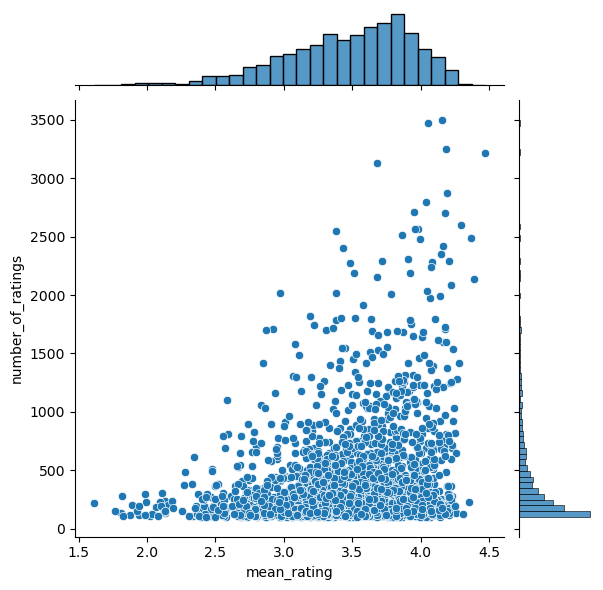

In [12]:
sns.jointplot(x='mean_rating',y='number_of_ratings',data=AGG_Ratings_GT100)

To keep only the 134 movies with more than 100 ratings, we need to join the movie with the user-rating level dataframe.

`how='inner'` and `on='title'` ensure that only the movies with more than 100 ratings are included.

In [13]:
df_GT100=pd.merge(df,AGG_Ratings_GT100[['title']],on='title',how='inner')

In [14]:
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860623 entries, 0 to 860622
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     860623 non-null  int64  
 1   movieId    860623 non-null  int64  
 2   rating     860623 non-null  float64
 3   timestamp  860623 non-null  object 
 4   title      860623 non-null  object 
 5   genres     860623 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 46.0+ MB


In [15]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 7120 unique users
The ratings dataset has 2110 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


# Step 4: Create User-Movie Matrix

In step 4, we will transform the dataset into a matrix format. The rows of the matrix are users, and the columns of the matrix are movies. The value of the matrix is the user rating of the movie if there is a rating. Otherwise, it shows 'NaN'.

In [16]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')
matrix.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),127 Hours (2010),13 Going on 30 (2004),"13th Warrior, The (1999)",1408 (2007),...,Young Guns II (1990),Young Sherlock Holmes (1985),Zack and Miri Make a Porno (2008),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 5: Data Normalization

Since some people tend to give a higher rating than others, we normalize the rating by extracting the average rating of each user.

After normalization, the movies with a rating less than the user's average rating get a negative value, and the movies with a rating more than the user's average rating get a positive value.

In [17]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),127 Hours (2010),13 Going on 30 (2004),"13th Warrior, The (1999)",1408 (2007),...,Young Guns II (1990),Young Sherlock Holmes (1985),Zack and Miri Make a Porno (2008),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 6: Identify Similar Users

There are different ways to measure similarities. Pearson correlation and cosine similarity are two widely used methods.

In this tutorial, we will calculate the user similarity matrix using Pearson correlation.

In [19]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,7111,7112,7113,7114,7115,7116,7117,7118,7119,7120
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.069338,0.225312,NaN,0.467677,NaN,0.110798,0.000000,0.000000,0.528761,...,0.510643,NaN,-0.288675,0.684653,0.102062,0.358154,0.270961,-0.476331,0.408248,0.577350
2,-0.069338,1.000000,-0.013023,NaN,0.645497,0.866025,0.534522,-0.408248,NaN,NaN,...,1.000000,NaN,-0.250000,NaN,0.333333,0.559939,-0.291111,0.739940,-0.577350,-0.500000
3,0.225312,-0.013023,1.000000,0.243975,-0.184208,-0.275839,0.023351,0.129823,0.688247,0.089041,...,0.438529,0.636364,-0.189389,0.353553,-0.092803,-0.034976,0.167866,-0.059761,0.075955,1.000000
4,NaN,NaN,0.243975,1.000000,0.164071,NaN,0.133631,0.585293,NaN,NaN,...,-0.755929,NaN,0.491429,NaN,0.028068,0.497253,-0.005595,NaN,-0.469157,NaN
5,0.467677,0.645497,-0.184208,0.164071,1.000000,0.145296,0.464860,-0.080766,NaN,NaN,...,NaN,NaN,0.049129,NaN,0.543771,-0.054297,0.089469,-0.560112,-0.392773,0.838525


In [49]:
from sklearn.metrics.pairwise import cosine_similarity

In [50]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[ 1.        ,  0.        ,  0.        , ...,  0.14893867,
        -0.06003146,  0.04528224],
       [ 0.        ,  1.        ,  0.        , ..., -0.04485403,
        -0.25197632,  0.18886414],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.14893867, -0.04485403,  0.        , ...,  1.        ,
         0.14734568,  0.07931015],
       [-0.06003146, -0.25197632,  0.        , ...,  0.14734568,
         1.        , -0.14276787],
       [ 0.04528224,  0.18886414,  0.        , ...,  0.07931015,
        -0.14276787,  1.        ]])

In [51]:
# Pick a user ID
picked_userid = input("Enter the user id")

# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)

# Take a look at the data
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,-0.583333,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,0.704669,0.055442,NaN,0.360399,...,-0.239325,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,...,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582
6,-0.439941,NaN,NaN,0.421927,-0.006888,1.000000,0.000000,-0.127385,NaN,0.957427,...,-0.292770,-0.030599,-0.123983,-0.176327,0.063861,-0.468008,0.541386,-0.337129,0.158255,-0.030567


In the user similarity matrix, the values range from -1 to 1, where -1 means opposite movie preference and 1 means same movie preference.
`n = 10` means we would like to pick the top 10 most similar users for user ID 1.

The user-based collaborative filtering makes recommendations based on users with similar tastes, so we need to set a positive threshold. Here we set the `user_similarity_threshold` to be 0.3, meaning that a user must have a Pearson correlation coefficient of at least 0.3 to be considered as a similar user.

After setting the number of similar users and similarity threshold, we sort the user similarity value from the highest and lowest, then printed out the most similar users' ID and the Pearson correlation value.



In [52]:
# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 1 are userId
108    1.000000
9      1.000000
550    1.000000
598    1.000000
502    1.000000
401    0.942809
511    0.925820
366    0.872872
154    0.866025
595    0.866025
Name: 1, dtype: float64


# Step 7: Narrow Down Item Pool

In [53]:
# Movies that the target user has watched
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

title,Alien (1979),American Beauty (1999),American History X (1998),Apocalypse Now (1979),Back to the Future (1985),Batman (1989),"Big Lebowski, The (1998)",Braveheart (1995),Clear and Present Danger (1994),Clerks (1994),...,Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Stargate (1994),"Terminator, The (1984)",Toy Story (1995),Twister (1996),"Usual Suspects, The (1995)",Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.392857,0.607143,0.607143,-0.392857,0.607143,-0.392857,0.607143,-0.392857,-0.392857,-1.392857,...,0.607143,0.607143,0.607143,-1.392857,0.607143,-0.392857,-1.392857,0.607143,0.607143,0.607143


In [54]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

title,Aladdin (1992),Alien (1979),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Back to the Future (1985),Batman Begins (2005),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),Blade Runner (1982),"Bourne Identity, The (2002)",Braveheart (1995),...,Shrek (2001),"Silence of the Lambs, The (1991)",Spider-Man (2002),Star Wars: Episode I - The Phantom Menace (1999),Terminator 2: Judgment Day (1991),Titanic (1997),Toy Story (1995),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008)
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,0.466667,0.466667,NaN,0.466667,NaN,0.466667,NaN,NaN,...,NaN,NaN,0.466667,NaN,NaN,-0.533333,NaN,NaN,NaN,NaN
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN,NaN
366,NaN,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,-0.205882,...,NaN,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,NaN
401,-0.382353,NaN,NaN,NaN,NaN,NaN,-0.382353,NaN,NaN,NaN,...,0.117647,NaN,NaN,NaN,NaN,NaN,0.117647,0.617647,NaN,0.617647
502,NaN,-0.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,NaN,-0.653846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.153846,-0.653846,NaN,NaN,NaN,-0.153846,NaN,NaN
550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.277778,0.222222,NaN,-0.277778
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.333333,NaN,NaN,NaN,NaN,0.666667,NaN


In [55]:
# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_movies

title,Aladdin (1992),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Batman Begins (2005),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),Blade Runner (1982),"Bourne Identity, The (2002)","Breakfast Club, The (1985)",Catch Me If You Can (2002),"Dark Knight, The (2008)",...,"Monsters, Inc. (2001)",Ocean's Eleven (2001),Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Shawshank Redemption, The (1994)",Shrek (2001),Spider-Man (2002),Terminator 2: Judgment Day (1991),Titanic (1997),Up (2009),WALL·E (2008)
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,0.466667,NaN,0.466667,NaN,0.466667,NaN,-0.533333,0.466667,NaN,...,NaN,NaN,NaN,NaN,NaN,0.466667,NaN,-0.533333,NaN,NaN
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN
366,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,NaN,NaN,-0.205882,...,NaN,NaN,-0.205882,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN
401,-0.382353,NaN,NaN,NaN,-0.382353,NaN,NaN,NaN,NaN,NaN,...,0.117647,NaN,0.117647,NaN,0.117647,NaN,NaN,NaN,0.617647,0.617647
502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.125000,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,-0.653846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.346154,NaN,-1.153846,NaN,NaN,-0.153846,NaN
550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.277778,-0.277778,...,NaN,NaN,NaN,0.222222,NaN,NaN,NaN,NaN,0.222222,-0.277778
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step-8:Recommend Items

In [56]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])

# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)

,movie,movie_score
16,Harry Potter and the Chamber of Secrets (2002),1.888889
13,Eternal Sunshine of the Spotless Mind (2004),1.888889
6,"Bourne Identity, The (2002)",0.888889
29,Ocean's Eleven (2001),0.888889
18,Inception (2010),0.587491
3,"Beautiful Mind, A (2001)",0.466667
5,Blade Runner (1982),0.466667
12,Donnie Darko (2001),0.466667
10,"Departed, The (2006)",0.256727
31,"Shawshank Redemption, The (1994)",0.222566
